In [233]:
%load_ext autoreload
%autoreload 2

import numpy as np


import sys
sys.path.append('../utils/plotting/')
sys.path.append('../utils/simulation/')
sys.path.append('../utils/recalibration/')
sys.path.append('../utils/preprocessing/')
from plotting_utils import figSize
from hmm import HMMRecalibration
from hmm_utils import *
from simulation import *
from simulation_utils import * 


# for a reproducible result
np.random.seed(1)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Define an initial decoder and initial neural tuning properties (mean firing rates and preferred directions).


In [248]:
'''The first column of initialTuning is the means, and the second two columns are the preferred directions. 
We make sure that the last two columns are orthogonal (uniformly distributed PDs) 
and that the tuning strength is set to 1 (norm of the column is 1). '''

'''The following is a really simple way to build a linear decoder based on the above tuning properties. 
First we define some velocity vectors (calVelocity), then simulate neural tuning to those vectors (calNeural),
and finally use ordinary least squares regression to find a decoder (D) that predicts calVelocity from calNeural. '''

from sklearn.linear_model import LinearRegression

nUnits          = 192
SNR             = 1
nTrainingSteps  = 10000

initialTuning          = generateUnits(n_units = nUnits, SNR = SNR)
calNeural, calVelocity = simulateUnitActivity(initialTuning, noise = 0.3, nSteps= nTrainingSteps)
lr                     = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)

D                      = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

# Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])
D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])




In [309]:
'''Here we define the amount of exponential smoothing used in the decoder (alpha). Values between 0.9 and 0.96 are pretty reasonable. See the paper
'A comparison of intention estimation methods for decoder calibration in intracortical brain-computer interfaces' for an explanation of how velocity Kalman 
filters can be parameterized with a smoothing parameter (alpha), gain parameter (beta, see next section below) and decoding matrix (D). '''

cfg = dict()
cfg['neuralTuning'] = initialTuning
cfg['D']            = D
cfg['alpha']        = 0.94
cfg['nDelaySteps']  = 20     # define the simulated user's visual feedback delay (200 ms)
cfg['delT']         = 0.01   # define the time step (10 ms)
cfg['nSimSteps']    = 5000  

### Do a quick sweep of cursor gains to find the optimal one for this task.

This is really important so that any new recalibration algorithm doesn't improve performance simply by coincidence,
via randomly changing the gain to some better value.

0 / 10
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10


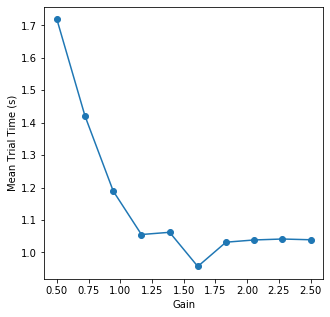

Using gain value beta =  1.8333333333333333


In [310]:
'''
The task we are simulating is a fitts style task where targets randomly
appear within a box centered at the origin. To acquire the target, the
user must hold the cursor on top of the target for half a second. The
performance metric of interest is the average total trial time (TTT), or
the average amount of time it takes to reach to and fully hold on a target. 

The 'simulateBCIFitts' does all the work of simulating the BCI user, the
neural activity, and the decoder. It returns time series data you can use
to see the cursor trajectory and target locations (posTraj & velTraj are
the cursor positions and velocities, rawDecTraj is the raw decoded
velocity vectors before they are smoothed, conTraj is the user's internal
control vector, targTraj is a time series of target locations, neuralTraj
is a time series of neural activity, trialStart contains the time step on
which each trial started, and ttt has the trial time (in seconds) for each
trial. '''

import matplotlib.pyplot as plt 
figSize(5,5)

possibleGain = np.linspace(0.5,2.5,10)
meanTTT      = np.zeros((len(possibleGain),))

for g in range(len(possibleGain)):
    print(str(g) + ' / ' + str(len(possibleGain)))
    cfg['beta'] = possibleGain[g]
    result      = simulateBCIFitts(cfg)
    meanTTT[g]  = np.mean(result['ttt'])

plt.figure()
plt.plot(possibleGain, meanTTT, '-o')
plt.xlabel('Gain')
plt.ylabel('Mean Trial Time (s)')
plt.show()

minIdx      = np.argmin(meanTTT)
cfg['beta'] = possibleGain[minIdx]

print('Using gain value beta = ', beta)


In [311]:
import copy 

# Simulate BCI performance with matched neural tuning and decoder, and an optimized gain
cfg['nSimSteps'] = 10000
shrinkage        = 0.4

results = simulateBCIFitts(cfg) 
                                                                                    
print('With a matched, optimized decoder, mean trial time is ', np.mean(results['ttt']), ' s')

# Simulate a change in neural tuning (specifically, change the PDs only, making sure the total magnitude of tuning is the same)
cfg['neuralTuning'] = simulateTuningShift(initialTuning, PD_shrinkage = shrinkage, renormalize = True)

results_new = simulateBCIFitts(cfg)
print('With changed tuning and a mismatched decoder, the mean trial time is ', np.mean(results_new['ttt']), ' s')

'''
This change in PDs effectively decrease the gain of the decoder, since the
tuning strength in the decoder subspace has decreased (factor of 0.3).
Here, we do a control to confirm that performance can't be restored simply
by increasing the gain by (1/0.3) and using the original decoder subspace.
'''

cfg_control          = copy.deepcopy(cfg)
cfg_control['beta'] /= shrinkage
results_control      = simulateBCIFitts(cfg_control)

print('Control: With changed tuning and a mismatched decoder with restored gain, the mean trial time is ', 
      np.mean(results_control['ttt']), ' s')


With a matched, optimized decoder, mean trial time is  1.0197938144329897  s
With changed tuning and a mismatched decoder, the mean trial time is  1.6832758620689654  s
Control: With changed tuning and a mismatched decoder with restored gain, the mean trial time is  2.08  s


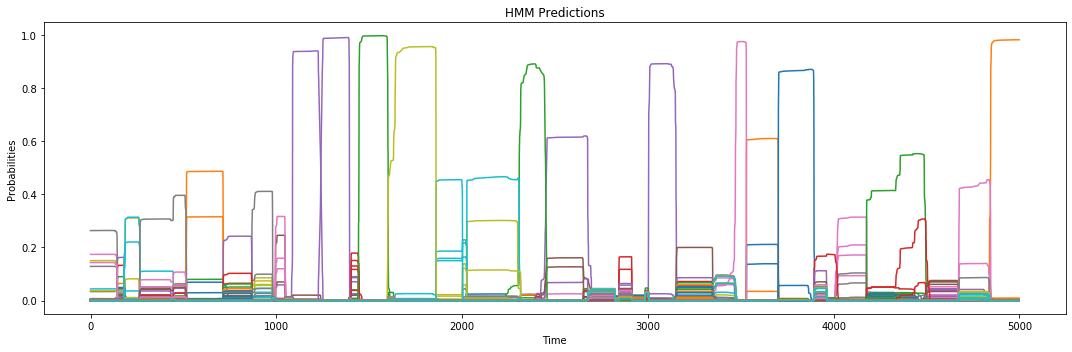

In [312]:
'''
Here we se a simple HMM to infer the user's intended targets from the raw (unsmoothed) decoded velocity vectors & cursor positions alone.
Each HMM state corresponds to one target location on a grid. First, get the grid of target locations.'''

gridSize    = 20
stayProb    = 0.9999

nStates                 = gridSize**2
targLocs                = generateTargetGrid(gridSize = gridSize)
stateTrans, pStateStart = generateTransitionMatrix(gridSize = gridSize, stayProb = stayProb)

# Precision parameter for the von mises distribution.
vmKappa = 2

'''
Infer target locations from the raw decoder output and cursor positions using the viterbi algorithm (finds most likely sequence) and the
forwards/backwards algorithm (to find the probabilities). These are custom functions that I made by modifying the MATLAB hmm routines 
(hmmviterbi & hmmdecode). '''


hmm = HMMRecalibration(stateTrans, targLocs, pStateStart, vmKappa, adjustKappa = None)

targStates, logP = hmm.viterbi_search(results_new['rawDecTraj'], results_new['posTraj'])
pTargState, pSeq = hmm.decode(results_new['rawDecTraj'], results_new['posTraj'])
    
#We can find time periods of high certainty, which may be of interest.
maxProb     = np.max(pTargState, axis = 0)
highProbIdx = np.where(maxProb > 0.8)[0]

figSize(5, 15)
_ = plt.plot(pTargState[:, :5000].T)
plt.title('HMM Predictions')
plt.xlabel('Time')
plt.ylabel('Probabilities')
plt.tight_layout()
plt.show()

Correlation between inferred target locations and true locations:  [0.89535202 0.87813576]
Correlation between inferred target locations and true locations for periods of high certainty:  [0.93882216 0.93144892]


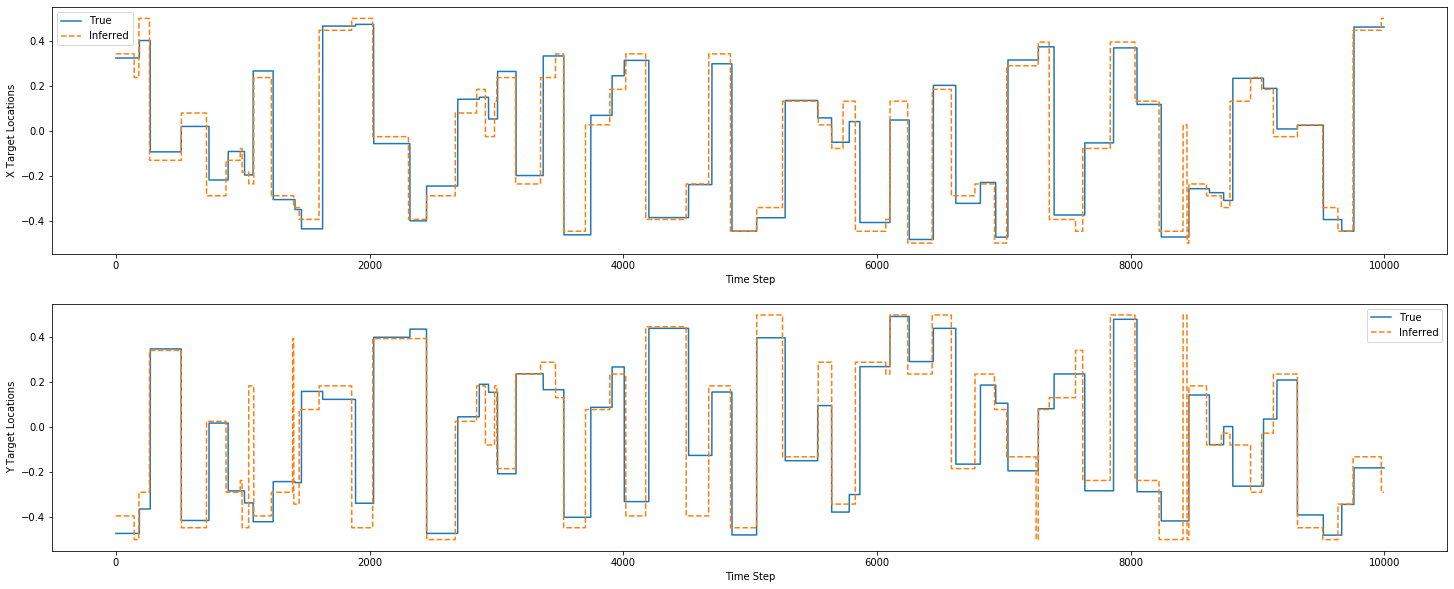

In [313]:
#See how well the inferred target locations match the true target locations.
inferredTargLoc = targLocs[targStates.astype('int').flatten(),:]

print('Correlation between inferred target locations and true locations: ', np.diag(np.corrcoef(results_new['targTraj'].T, inferredTargLoc.T), 2))
print('Correlation between inferred target locations and true locations for periods of high certainty: ', np.diag(np.corrcoef(results_new['targTraj'][highProbIdx, :].T, inferredTargLoc[highProbIdx, :].T), 2))

figSize(10, 25)

labels = ['X', 'Y']
for i in range(2):
    plt.subplot(2, 1, i + 1)
    plt.plot(results_new['targTraj'][:, i], label = 'True')
    plt.plot(inferredTargLoc[:, i],'--', label = 'Inferred')
    plt.xlabel('Time Step')
    plt.ylabel(labels[i] + ' Target Locations')
    plt.legend()
plt.show()

In [314]:
def normalizeDecoderGain(D, decPosErr, posErr, farThresh = 0.4, weights = None):
    '''Inputs are:
    
        D (2D float array)      - (channels + 1) x 2 array of decoder weights 
        posErr (2D float array) - nSamples x 2 array of displacement vectors (from target)
        weights (1D array)      - nSamples array of importance weights for each sample 
                                  (default: weight equally)
    '''
    
    assert (decPosErr.shape == posErr.shape), "Predicted and inferred displacement must be same shape"
    
    if weights is None:
        weights = np.ones((decPosErr.shape[0],))
    
    targDist = np.linalg.norm(posErr, axis = 1)
    targDir  = posErr / targDist[:, np.newaxis]
    farIdx   = np.where(targDist > farThresh)[0]
    
    
    projVec  = np.multiply(decPosErr, targDir)
    projVec *= weights[:, None] 
    
    projMag = np.sum(projVec, axis = 1)
    projMag = np.multiply(weights, projMag)
    
    meanMag  = np.sum(projMag[farIdx]) / np.sum(weights[farIdx])
        
    D_new    = D / meanMag

    return D_new
    
    

In [318]:

# Now recalibrate the decoder based on the inferred targets.
inferredPosErr = inferredTargLoc - results_new['posTraj']

lr             = LinearRegression(fit_intercept = True).fit(results_new['neuralTraj'], inferredPosErr, (maxProb > 0.4).astype(float))
D_new          = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_ ]).T
decVec_new     = np.hstack([np.ones((results_new['neuralTraj'].shape[0],1)),results_new['neuralTraj']]).dot(D_new)


#Important: normalize the decoder so that D_new decoders vectors of magnitude 1 when far from the target. 
#This will restore the original optimal gain.

D_new   = normalizeDecoderGain(D_new, decVec_new, truePosErr, farThresh = 0.4, weights = None)


#Simulate BCI performance with the new decoder
cfg_recal      = copy.deepcopy(cfg)
cfg_recal['D'] = D_new

results_recal  = simulateBCIFitts(cfg_recal)

print('Recalibrating the decoder with inferred HMM targets, the mean trial time is ', np.mean(results_recal['ttt']), ' s')

# Now do the same thing, but using the true targets, so we can compare to
# the performance of supervised recalibration.
truePosErr         = results_new['targTraj'] - results_new['posTraj']
D_supervised       = np.linalg.lstsq(np.hstack([np.ones((results_new['neuralTraj'].shape[0],1)), results_new['neuralTraj']]), truePosErr, rcond = -1)[0]
decVec_trueControl = np.hstack([np.ones((results_new['neuralTraj'].shape[0],1)), results_new['neuralTraj']]).dot(D_supervised)


D_supervised       = normalizeDecoderGain(D_supervised, decVec_trueControl, truePosErr, farThresh = 0.4, weights = None)

cfg_supervised      = copy.deepcopy(cfg)
cfg_supervised['D'] = D_supervised


results_supervised = simulateBCIFitts(cfg_supervised)

print('Recalibrating the decoder with the true targets, the mean trial time is ', np.mean(results_supervised['ttt']), ' s')

Recalibrating the decoder with inferred HMM targets, the mean trial time is  1.0713978494623655  s
Recalibrating the decoder with the true targets, the mean trial time is  1.0906593406593408  s


X  correlation:  0.9536653007222887
X  bias:  -0.6453412497242966 -0.8645683258942429
Y  correlation:  0.9498128436429252
Y  bias:  0.9209679998309473 0.9549414265956327


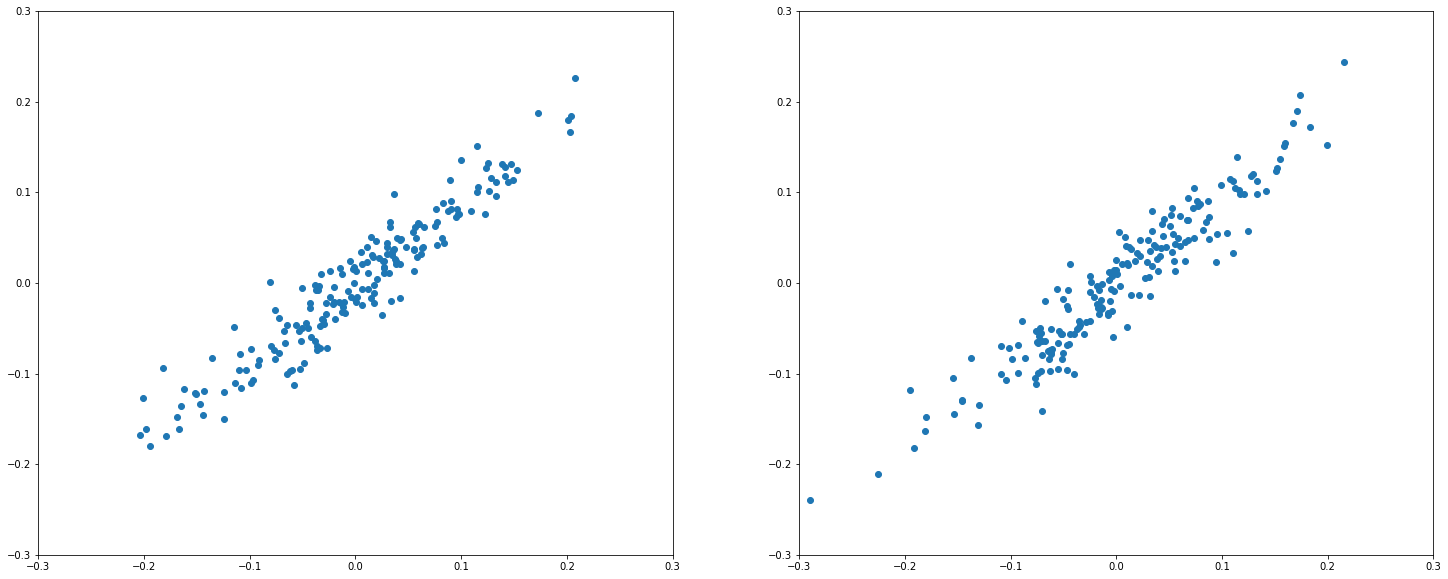

In [319]:
for i, coord in enumerate(['X', 'Y']):
    print(coord, ' correlation: ', np.corrcoef(D_new[1:, i], D_supervised[1:, i])[0, 1])
    print(coord, ' bias: ', D_new[0, i], D_supervised[0, i])
    
    plt.subplot(1, 2, i+1)
    plt.scatter(D_new[1:, i], D_supervised[1:, i])
    plt.xlim([-0.3, 0.3])
    plt.ylim([-0.3, 0.3])
plt.show()

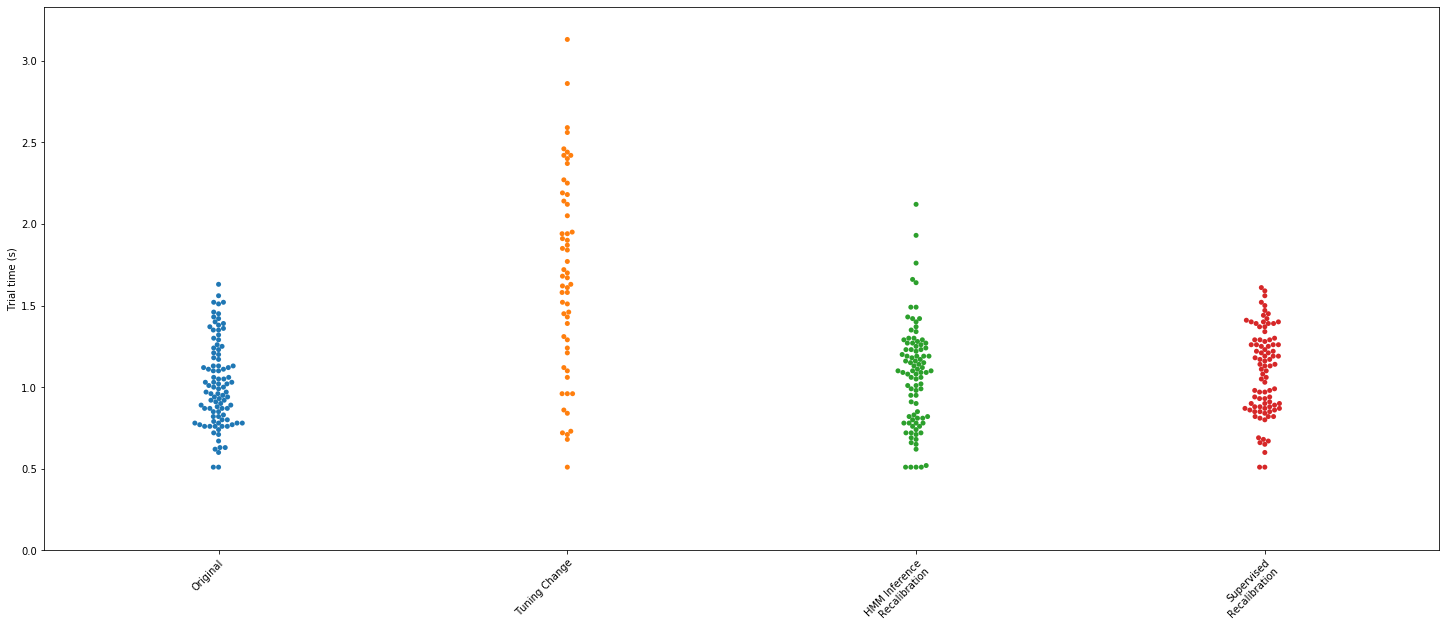

In [320]:
'''
Summarize the performance for all 4 relevant conditions: original performance, performance when the tuning changes (but the decoder
doesn't), performance with the HMM-powered unsupervised recalibration, and performance with supervised recalibration. 
We plot means and 95% CIs.
'''

from scipy.stats import norm
import seaborn as sns

groups = [results['ttt'], results_new['ttt'], results_recal['ttt'], results_supervised['ttt']]

sns.swarmplot(data = groups)
ax = plt.gca()
labels = ['Original','Tuning Change','HMM Inference\nRecalibration','Supervised\nRecalibration']
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.ylabel('Trial time (s)')
plt.ylim([0, max([max(i) for i in groups]) + 0.2])
plt.show()